In [2]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [121]:
# Importing data (without quantile transforms)
new_df2 = pd.read_csv("./Datasets/2021-08-07 new_df2.csv")
new_df2_dropna = pd.read_csv("./Datasets/2021-08-07 new_df2_dropna.csv")


In [30]:
new_df2.columns

Index(['year', 'country', 'is_war', 'n_conflicts', 'total_deaths',
       'incompatibility', 'intensity', 'type_of_conflict', 'conflict_before',
       'countryname', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'intrastate_conflict',
       'interstate_conflict', 'Country_x', 'Year_x', 'ForeignAid', 'Resources',
       'EthFrac', 'LingFrac', 'RelFrac', 'Transitional', 'AC_neighbour',
       'GDP_capita', 'Population', 'Population_log', 'GDP_capita_log',
       'ForeignAid_log', 'conflict_type', 'Year_y', 'Session', 'ISO Code',
       'Country_y', 'person', 'Post', 'Language', 'Notes'],
      dtype='object')

Controling for countries and not controling for countries (run two regressions, separately)

**Run models**:
 - while controling for countries (fixed effects) vs not controling (pooled data)
 - while using just indices, just controls, and both
 - create a table where I showcase best model for all
 - create explanatory features
 - see if this differs for data when the indices are quantile-transformed

In [910]:
cols_simple = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23']

cols_control_country = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'countryname']

I compare 26 models

In [925]:
X = new_df2[cols_control_country]
y = new_df2['intrastate_conflict']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state =123)

# Initialize classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

# Predict model
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.08it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.85               0.68     0.68      0.84   
LGBMClassifier                     0.86               0.68     0.68      0.84   
LabelPropagation                   0.78               0.66     0.66      0.79   
LabelSpreading                     0.78               0.66     0.66      0.79   
KNeighborsClassifier               0.83               0.66     0.66      0.81   
AdaBoostClassifier                 0.82               0.64     0.64      0.80   
DecisionTreeClassifier             0.74               0.61     0.61      0.75   
Perceptron                         0.75               0.59     0.59      0.75   
GaussianNB                         0.77               0.57     0.57      0.75   
NearestCentroid                    0.56               0.56     0.56      0.61   
BaggingClassifier           

In [926]:
len(models)

26

In [927]:
print(models.drop('Time Taken', axis=1).sort_values('F1 Score', ascending=False).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Balanced Accuracy &  ROC AUC &  F1 Score \\
Model                         &           &                    &          &           \\
\midrule
LGBMClassifier                &      0.86 &               0.68 &     0.68 &      0.84 \\
XGBClassifier                 &      0.85 &               0.68 &     0.68 &      0.84 \\
KNeighborsClassifier          &      0.83 &               0.66 &     0.66 &      0.81 \\
AdaBoostClassifier            &      0.82 &               0.64 &     0.64 &      0.80 \\
LabelPropagation              &      0.78 &               0.66 &     0.66 &      0.79 \\
LabelSpreading                &      0.78 &               0.66 &     0.66 &      0.79 \\
BaggingClassifier             &      0.81 &               0.55 &     0.55 &      0.76 \\
BernoulliNB                   &      0.81 &               0.54 &     0.54 &      0.75 \\
RandomForestClassifier        &      0.82 &               0.53 &     0.53 &      0.75 \\
Gaussia

In [59]:
for cols in [cols_simple, cols_control_country]:
    X = new_df2[cols]
    y = new_df2['intrastate_conflict']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state =123)

    # Initialize classifier
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

    # Predict model
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)

    print(models)


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.66               0.62     0.62      0.69   
SGDClassifier                      0.75               0.59     0.59      0.75   
LabelPropagation                   0.73               0.58     0.58      0.74   
LabelSpreading                     0.73               0.58     0.58      0.74   
GaussianNB                         0.77               0.57     0.57      0.75   
LGBMClassifier                     0.81               0.56     0.56      0.77   
KNeighborsClassifier               0.80               0.55     0.55      0.76   
XGBClassifier                      0.80               0.55     0.55      0.75   
BaggingClassifier                  0.80               0.54     0.54      0.75   
QuadraticDiscriminantAnalysis      0.75               0.54     0.54      0.73   
Perceptron                  

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.10it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.85               0.68     0.68      0.84   
LGBMClassifier                     0.86               0.68     0.68      0.84   
LabelPropagation                   0.78               0.66     0.66      0.79   
LabelSpreading                     0.78               0.66     0.66      0.79   
KNeighborsClassifier               0.83               0.66     0.66      0.81   
AdaBoostClassifier                 0.82               0.64     0.64      0.80   
DecisionTreeClassifier             0.74               0.61     0.61      0.75   
Perceptron                         0.75               0.59     0.59      0.75   
GaussianNB                         0.77               0.57     0.57      0.75   
NearestCentroid                    0.56               0.56     0.56      0.61   
BaggingClassifier           

In [799]:
plot_way = models.index

In [61]:
new_df2.columns

Index(['year', 'country', 'is_war', 'n_conflicts', 'total_deaths',
       'incompatibility', 'intensity', 'type_of_conflict', 'conflict_before',
       'countryname', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'intrastate_conflict',
       'interstate_conflict', 'Country_x', 'Year_x', 'ForeignAid', 'Resources',
       'EthFrac', 'LingFrac', 'RelFrac', 'Transitional', 'AC_neighbour',
       'GDP_capita', 'Population', 'Population_log', 'GDP_capita_log',
       'ForeignAid_log', 'conflict_type', 'Year_y', 'Session', 'ISO Code',
       'Country_y', 'person', 'Post', 'Language', 'Notes'],
      dtype='object')

In [62]:
cols_simple = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'Population_log', 'GDP_capita_log',
       'ForeignAid_log', 'Resources',
       'EthFrac', 'LingFrac', 'RelFrac', 'Transitional', 'AC_neighbour']

cols_control_country = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'Population_log', 'GDP_capita_log',
       'ForeignAid_log', 'Resources',
       'EthFrac', 'LingFrac', 'RelFrac', 'Transitional', 'AC_neighbour', 'countryname']

In [63]:
for cols in [cols_simple, cols_control_country]:
    X = new_df2_dropna[cols]
    y = new_df2_dropna['intrastate_conflict']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state =123)

    # Initialize classifier
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

    # Predict model
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)

    print(models)


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.87               0.75     0.75      0.87   
LGBMClassifier                     0.88               0.75     0.75      0.87   
NearestCentroid                    0.75               0.73     0.73      0.77   
BaggingClassifier                  0.87               0.71     0.71      0.86   
AdaBoostClassifier                 0.85               0.68     0.68      0.83   
DecisionTreeClassifier             0.81               0.68     0.68      0.81   
ExtraTreeClassifier                0.79               0.68     0.68      0.80   
RandomForestClassifier             0.86               0.67     0.67      0.84   
SGDClassifier                      0.77               0.67     0.67      0.78   
GaussianNB                         0.82               0.67     0.67      0.81   
KNeighborsClassifier        

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.00it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.89               0.78     0.78      0.88   
XGBClassifier                      0.87               0.73     0.73      0.86   
BaggingClassifier                  0.87               0.73     0.73      0.86   
AdaBoostClassifier                 0.84               0.72     0.72      0.84   
LabelPropagation                   0.81               0.71     0.71      0.81   
LabelSpreading                     0.81               0.71     0.71      0.81   
DecisionTreeClassifier             0.83               0.71     0.71      0.83   
KNeighborsClassifier               0.85               0.70     0.70      0.84   
RandomForestClassifier             0.87               0.69     0.69      0.85   
ExtraTreesClassifier               0.87               0.68     0.68      0.85   
GaussianNB                  

In [ ]:
X = new_df2[cols]
y = new_df2['intrastate_conflict']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state =123)

# Initialize classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

# Predict model
models,predictions = clf.fit(X_train, X_test, y_train, y_test)


In [114]:
adaboost = clf.classifiers[0][1]

In [116]:
adaboost.coef_

AttributeError: type object 'AdaBoostClassifier' has no attribute 'coef_'

In [110]:
clf.pre

### Feature importance

#### Only the indices (nothing else).

In [65]:
from xgboost import XGBClassifier


In [66]:
from matplotlib import pyplot

In [72]:
X = new_df2[cols_simple]
y = new_df2['intrastate_conflict']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state =123)

In [73]:
model = XGBClassifier()

[0.04492916 0.03526258 0.04338798 0.03703839 0.05012276 0.05131616
 0.04630027 0.03406532 0.04378146 0.04208605 0.03961528 0.04565319
 0.03251608 0.03475999 0.0412081  0.03730575 0.03747604 0.06504256
 0.05130789 0.04451293 0.05500172 0.04009924 0.04721121]


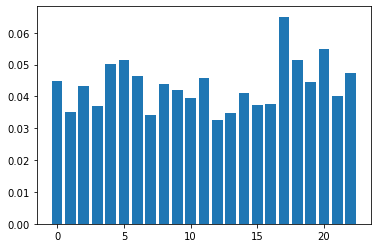

In [74]:
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [76]:
from xgboost import plot_importance


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

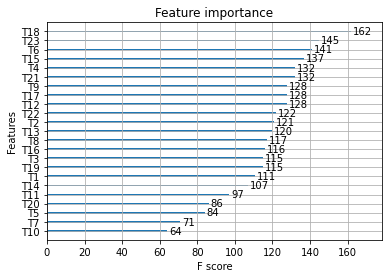

In [77]:
plot_importance(model)


In [80]:
import xgboost as xgb


In [83]:
dmatrix = xgb.DMatrix(data=X, label=y)

In [84]:
params={ 'objective':'binary:logistic',
         'max_depth': 6, 
         'colsample_bylevel':0.5,
         'learning_rate':0.01,
         'random_state':20}

In [94]:
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'auc'}, as_pandas=True, seed=20, num_boost_round=1000)

Default model is 0.75

In [97]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.74,0.02,0.60,0.05
1,0.79,0.02,0.62,0.04
2,0.81,0.01,0.62,0.04
3,0.83,0.01,0.63,0.04
4,0.83,0.01,0.64,0.04
...,...,...,...,...
995,1.00,0.00,0.69,0.03
996,1.00,0.00,0.69,0.03
997,1.00,0.00,0.69,0.03
998,1.00,0.00,0.69,0.03


In [96]:
cv_results['test-auc-mean'].max()

0.6906939000000001

In [104]:
importances = ['total_gain', 'gain', 'total_cover', 'cover', 'weight']

“The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
The Coverage metric means the relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.
The Frequency (R)/Weight (python) is the percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.
The Gain is the most relevant attribute to interpret the relative importance of each feature.
‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite).
‘Coverage’ measures the relative quantity of observations concerned by a feature.”[3]

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Different feature importance scores (!!) --> look at them :] 

In [106]:
for imp in importances:
    print("-------------------------")
    print(imp)
    print(model.get_booster().get_score(importance_type=imp))

-------------------------
total_gain
{'T18': 377.2443575936999, 'T21': 259.9323694505, 'T5': 150.73857153470001, 'T6': 259.0499036234, 'T4': 175.03953169809202, 'T22': 175.1483868179, 'T12': 209.21423016780005, 'T2': 152.75998301170003, 'T17': 171.74092301179994, 'T11': 137.5766241446, 'T19': 211.24778326979992, 'T3': 178.63945097800004, 'T1': 178.55064682036001, 'T14': 133.15993714430002, 'T15': 202.12186332000005, 'T23': 245.08868993009992, 'T7': 117.69336123699995, 'T8': 142.69492025306997, 'T13': 139.6977831782, 'T20': 137.0549560724, 'T16': 154.93298544259994, 'T10': 96.43357163600002, 'T9': 200.6366579868001}
-------------------------
gain
{'T18': 2.328668874035184, 'T21': 1.9691846170492424, 'T5': 1.794506803984524, 'T6': 1.8372333590312055, 'T4': 1.3260570583188789, 'T22': 1.4356425149008196, 'T12': 1.634486173185938, 'T2': 1.262479198443802, 'T17': 1.341725961029687, 'T11': 1.4183157128309278, 'T19': 1.8369372458243471, 'T3': 1.5533865302434786, 'T1': 1.608564385769009, 'T14':

### Get all model feature importances

In [511]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = MinMaxScaler()

In [512]:
cols_simple = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23']

cols_control_country = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'countryname']

X = new_df2[cols_simple]
y = new_df2['intrastate_conflict']

# standardize
X_transf = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_transf, y, test_size=.30, random_state =123)


In [513]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

# Predict model
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.28it/s]


In [514]:
models_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)

In [515]:
# Get parameters for all the models in the appendix

In [516]:
def bag_importance(v):
    # Bagging Classifier -> average importance of all trees
    estimators = v[-1].estimators_
    estimators_avg = []
    for estimator in estimators:
        estimators_avg.append(estimator.feature_importances_)
    model = np.mean(estimators_avg, axis=0)
    return model

In [517]:
def bernoulli(v):
    # Naive Bayes -> largest absolute magnitude value
    two_importances = v[-1].feature_log_prob_
    imp_ls = []
    for imp in two_importances:
        imp_ls.append([abs(x) for x in imp])
    importances = np.max(imp_ls, axis=0)
    return importances

In [518]:
def feature_importances(v):
    return v[-1].coef_

In [519]:
d.get_params()

{'constant': None, 'random_state': 42, 'strategy': 'warn'}

In [520]:
def calibrated(v):
    # Weighted average of estimators (separate)
    cc = v[-1]
    coef_avg = 0
    for i in cc.calibrated_classifiers_:
        coef_avg = coef_avg + i.base_estimator.coef_
    coef_avg  = coef_avg/len(cc.calibrated_classifiers_)
    return coef_avg[0]

In [521]:
from sklearn.inspection import permutation_importance


Coefficients are standardized to calculate feature importance

In [522]:
for col in X_test.columns:
    print(col, X_test[col].max())

T1 1.0
T2 0.9823284823284824
T3 1.0
T4 0.9130434782608696
T5 0.7342657342657343
T6 0.7763157894736838
T7 0.5382223993622955
T8 0.9672727272727272
T9 0.9589743589743589
T10 0.7551020408163261
T11 0.9338089575901705
T12 0.8624999999999999
T13 0.783673469387755
T14 0.9168539325842694
T15 1.0
T16 0.6838235294117646
T17 0.6857142857142856
T18 1.0
T19 0.9434187016081
T20 0.734658599827139
T21 0.9880701754385963
T22 0.7222222222222223
T23 1.0


In [928]:
model_dict = {}
for k, v in models_dictionary.items():
    print(k)
    if k == 'BaggingClassifier': model = bag_importance(v)
    elif k == 'BernoulliNB': model = bernoulli(v)
    elif k == 'CalibratedClassifierCV': model = calibrated(v)
    elif k == 'DummyClassifier': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests # Permutation tests
    elif k == 'GaussianNB': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests
    elif k == 'KNeighborsClassifier': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests # Permutation tests
    elif k == 'LabelPropagation': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'LabelSpreading': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean
    elif k == 'LinearDiscriminantAnalysis': model = feature_importances(v)
    elif k == 'LinearSVC': model = feature_importances(v)
    elif k == 'LogisticRegression': model = feature_importances(v)
    elif k == 'PassiveAggressiveClassifier': model = feature_importances(v)
    elif k in ['Perceptron', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier']: model = feature_importances(v)
    elif k == 'QuadraticDiscriminantAnalysis': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'SVC': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'NearestCentroid': model = np.zeros(23)
    else: 
        model = v[-1].feature_importances_
        print("weights")
    print(model)
    
    model_dict[k] = model

AdaBoostClassifier
weights
[0.06 0.04 0.   0.06 0.06 0.04 0.06 0.02 0.02 0.04 0.   0.06 0.02 0.02
 0.06 0.06 0.02 0.1  0.04 0.06 0.02 0.04 0.1 ]
BaggingClassifier
[0.01958863 0.04704859 0.04898917 0.05698095 0.04460395 0.06605758
 0.02279833 0.02999072 0.03002358 0.02158679 0.03239454 0.04853201
 0.03588677 0.03348822 0.0515516  0.03391095 0.03982158 0.09055869
 0.04373214 0.03347873 0.06143603 0.04965523 0.05788521]
BernoulliNB
[1.12873505 0.84388489 0.83647631 1.09269511 1.19511012 1.04304244
 0.96027053 1.00789857 1.057909   1.06649274 1.057909   0.87678829
 0.87844051 1.12873505 0.83878717 0.9297338  0.90742804 0.96700582
 1.03476082 1.16612258 1.03476082 0.92224313 1.04939831]
CalibratedClassifierCV
[-0.01623481  0.01880657  0.02171037 -0.04158136  0.04319486  0.1316092
 -0.0176584  -0.01860098 -0.01220535  0.00692653  0.0140726   0.0776497
 -0.0055257  -0.02988887  0.02453145  0.02350035 -0.0145525   0.1497119
  0.00846661 -0.01553232  0.10466084  0.03795323  0.02267258]
Decision

ValueError: could not convert string to float: 'Nigeria'

In [546]:
model_dict = {}
for k, v in models_dictionary.items():
    print(k)
    if k == 'BaggingClassifier': model = bag_importance(v)
    elif k == 'BernoulliNB': model = bernoulli(v)
    elif k == 'CalibratedClassifierCV': model = calibrated(v)
    elif k == 'DummyClassifier': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests # Permutation tests
    elif k == 'GaussianNB': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests
    elif k == 'KNeighborsClassifier': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation tests # Permutation tests
    elif k == 'LabelPropagation': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'LabelSpreading': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean
    elif k == 'LinearDiscriminantAnalysis': model = feature_importances(v)
    elif k == 'LinearSVC': model = feature_importances(v)
    elif k == 'LogisticRegression': model = feature_importances(v)
    elif k == 'PassiveAggressiveClassifier': model = feature_importances(v)
    elif k in ['Perceptron', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier']: model = feature_importances(v)
    elif k == 'QuadraticDiscriminantAnalysis': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'SVC': model = permutation_importance(v[-1], X_test, y_test, scoring='roc_auc').importances_mean # Permutation test
    elif k == 'NearestCentroid': model = np.zeros(23)
    else: 
        model = v[-1].feature_importances_
        print("weights")
    print(model)
    
    model_dict[k] = model

AdaBoostClassifier
[0.06 0.04 0.   0.06 0.06 0.04 0.06 0.02 0.02 0.04 0.   0.06 0.02 0.02
 0.06 0.06 0.02 0.1  0.04 0.06 0.02 0.04 0.1 ]
BaggingClassifier
[0.01958863 0.04704859 0.04898917 0.05698095 0.04460395 0.06605758
 0.02279833 0.02999072 0.03002358 0.02158679 0.03239454 0.04853201
 0.03588677 0.03348822 0.0515516  0.03391095 0.03982158 0.09055869
 0.04373214 0.03347873 0.06143603 0.04965523 0.05788521]
BernoulliNB
[1.12873505 0.84388489 0.83647631 1.09269511 1.19511012 1.04304244
 0.96027053 1.00789857 1.057909   1.06649274 1.057909   0.87678829
 0.87844051 1.12873505 0.83878717 0.9297338  0.90742804 0.96700582
 1.03476082 1.16612258 1.03476082 0.92224313 1.04939831]
CalibratedClassifierCV
[-0.01623481  0.01880657  0.02171037 -0.04158136  0.04319486  0.1316092
 -0.0176584  -0.01860098 -0.01220535  0.00692653  0.0140726   0.0776497
 -0.0055257  -0.02988887  0.02453145  0.02350035 -0.0145525   0.1497119
  0.00846661 -0.01553232  0.10466084  0.03795323  0.02267258]
DecisionTreeClas

In [562]:
nest_items = [k for k,v in model_dict.items() if len(v) == 1 ]
for k in nest_items:
    model_dict[k] = model_dict[k][0]

In [565]:
df_temp = pd.DataFrame(model_dict.items())

In [579]:
df_predicts = df_temp[[0]].merge(df_temp[1].apply(pd.Series), left_index=True, right_index=True)

In [581]:
Ts = ['T' + str(x) for x in range(1,24)]
cols = ['Classifier'] + Ts
df_predicts.columns = cols

In [587]:
df_predicts = df_predicts.set_index("Classifier")

In [607]:
def get_topn(index, n=3):
    return {kv[0]:i+1 for i, kv in enumerate(dict(df_predicts.loc[index].nlargest(n)).items())}

In [608]:
get_topn('BernoulliNB')

{'T5': 1, 'T20': 2, 'T1': 3}

In [616]:
df_top = df_predicts.copy()

In [621]:
# Loop over all classifiers
for cl in df_top.index:
    
    # Get the top three classifiers
    topn = get_topn(cl)
    
    # For all the  top classifiers, replace them with numbers 1,2,3
    for k, v in topn.items():
        df_top.loc[cl, k] = v
    
    # For all the other indices, replace them with zero if they are not among the top classifiers
    for k in df_top.keys():
        if k in list(topn.keys()): pass
        else: df_top.loc[cl, k] = 0

In [623]:
import seaborn as sns

In [693]:
cmap = sns.diverging_palette(20,230, as_cmap=True)

In [694]:
cmap

In [812]:
my_colors=['#EFEFEF','#561608','#C3553A','#DFC4BE']


In [813]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']


In [ ]:
df_top.loc['NearestCentroid', ['T1', 'T2', 'T3']] = [0,0,0]
df_top.loc['DummyClassifier', ['T1', 'T2', 'T3']] = [0,0,0]
plot_df_top = df_top[~df_top.index.isin(['NearestCentroid', 'DummyClassifier'])]

In [791]:
def set_sizes(plt):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 18
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    

In [820]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [821]:
my_colors=['#F0F0F0','#561608','#C3553A','#DFC4BE']


In [825]:
import matplotlib.patches as mpatches

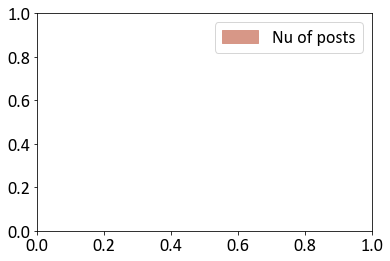

In [901]:
# Create a legend
import matplotlib.patches as mpatches
normal_patch = plt.Rectangle((10, 0.75), 0.4, 0.15, color='#D79787', label='Nu of posts')
plt.legend(handles=[normal_patch])

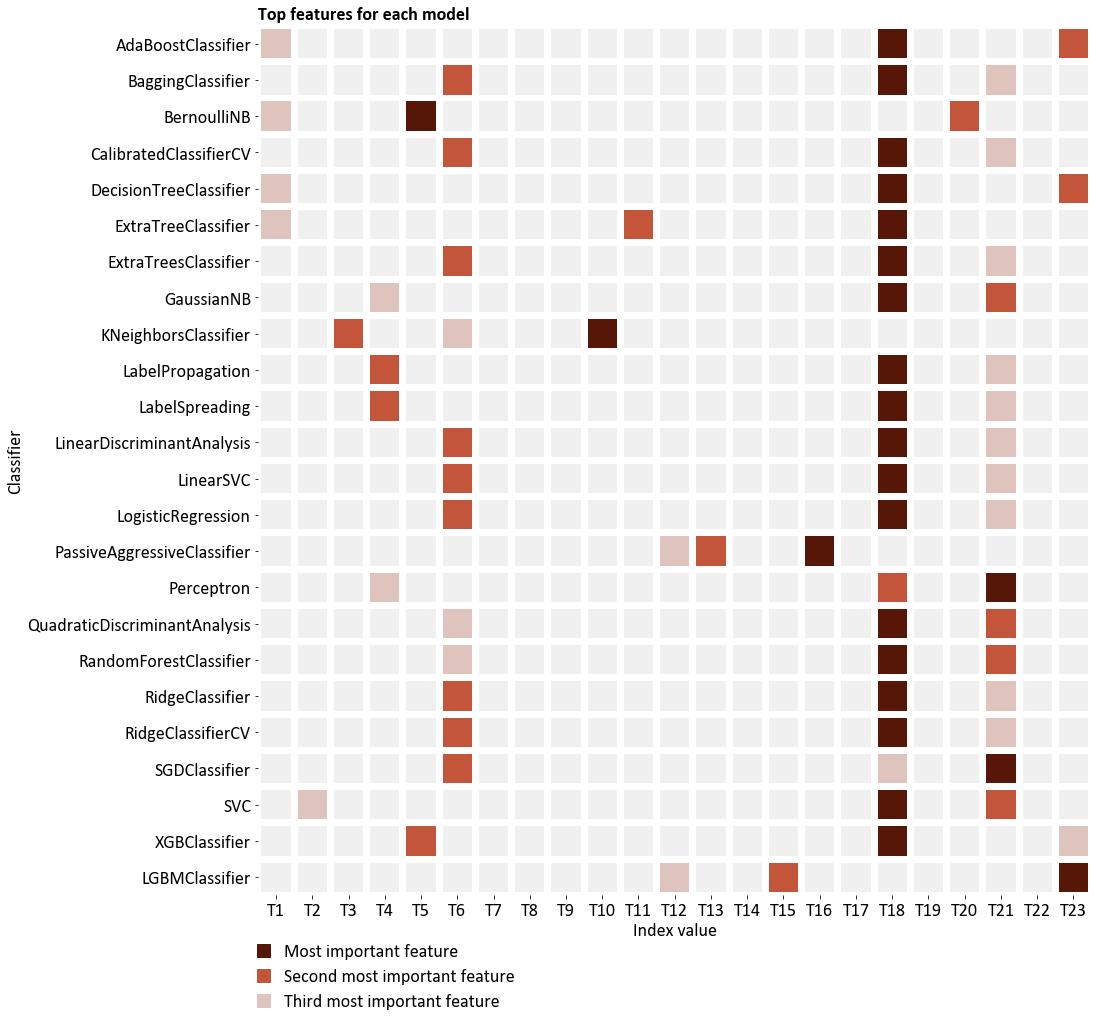

In [924]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

plt.rcParams["font.family"] = "Calibri"

sns.heatmap(plot_df_top, ax=ax, square=True, cmap=my_colors, linewidth=6, linecolor='white', cbar=False, cbar_kws={'ticks': [0,1,2,3], 'orientation': 'horizontal', 'shrink': 0.7})
#colorbar = ax.colections[0].colorbar

#colorbar.set_ticklabels(["", "1", "two", "Three"])
ax.set_xlabel("Index value", **hfont)
ax.set_ylabel("Classifier", **hfont)

# Set legend
ax.set_position([0.1,0.1,0.5,0.8])
ax.set_title("Top features for each model", loc='left', weight='bold', fontsize=18)
ax.legend(handles=[rect1, rect2, rect3], bbox_to_anchor=(-0.02, -0.15), loc='lower left', frameon=False, handlelength=0.7, fontsize=18)
plt.tight_layout()

#fig.savefig('./Figures/classifier_importance.pdf')

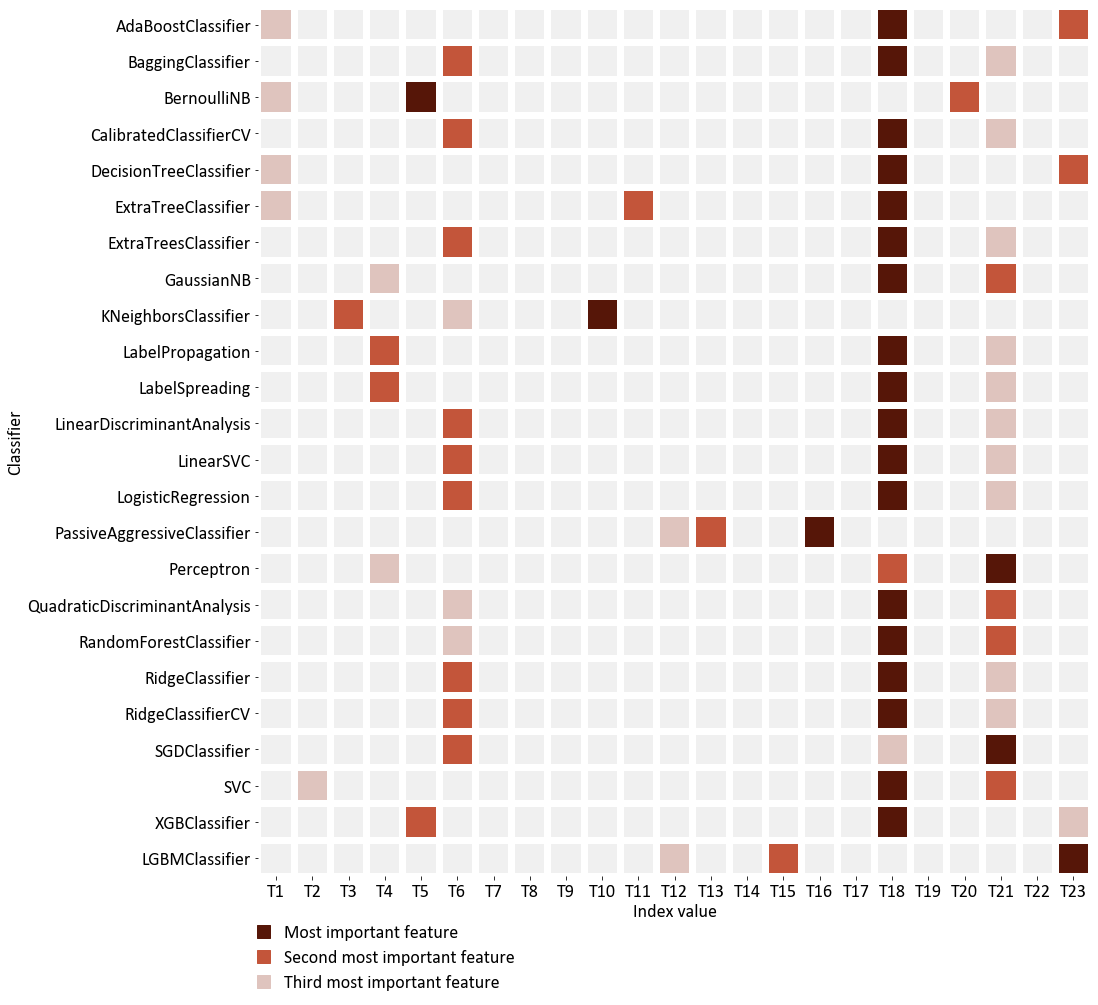

In [906]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

plt.rcParams["font.family"] = "Calibri"

sns.heatmap(plot_df_top, ax=ax, square=True, cmap=my_colors, linewidth=6, linecolor='white', cbar=False, cbar_kws={'ticks': [0,1,2,3], 'orientation': 'horizontal', 'shrink': 0.7})
#colorbar = ax.colections[0].colorbar

#colorbar.set_ticklabels(["", "1", "two", "Three"])
ax.set_xlabel("Index value", **hfont)
ax.set_ylabel("Classifier", **hfont)

# Set legend
ax.set_position([0.1,0.1,0.5,0.8])
ax.legend(handles=[rect1, rect2, rect3], bbox_to_anchor=(-0.02, -0.15), loc='lower left', frameon=False, handlelength=0.7, fontsize=18)
plt.tight_layout()

fig.savefig('./Figures/classifier_importance.pdf')

In [909]:
df_predicts.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23
Classifier,,,,,,,,,,,,,,,,,,,,,
AdaBoostClassifier,0.06,0.04,0.00,0.06,0.06,0.04,0.06,0.02,0.02,0.04,...,0.02,0.06,0.06,0.02,0.10,0.04,0.06,0.02,0.04,0.10
BaggingClassifier,0.02,0.05,0.05,0.06,0.04,0.07,0.02,0.03,0.03,0.02,...,0.03,0.05,0.03,0.04,0.09,0.04,0.03,0.06,0.05,0.06
BernoulliNB,1.13,0.84,0.84,1.09,1.20,1.04,0.96,1.01,1.06,1.07,...,1.13,0.84,0.93,0.91,0.97,1.03,1.17,1.03,0.92,1.05
CalibratedClassifierCV,-0.02,0.02,0.02,-0.04,0.04,0.13,-0.02,-0.02,-0.01,0.01,...,-0.03,0.02,0.02,-0.01,0.15,0.01,-0.02,0.10,0.04,0.02
DecisionTreeClassifier,0.06,0.04,0.03,0.05,0.04,0.05,0.03,0.02,0.03,0.02,...,0.02,0.05,0.05,0.04,0.09,0.05,0.04,0.06,0.05,0.08


In [908]:
df_predicts.to_csv("./Datasets/2021-08-08 predictions_importance.csv")